# Task 2: Sentiment and Thematic Analysis
___
### 1. Setup & Data Loading

In [1]:
import sys
import os

# Add project root (one directory above "notebooks")
sys.path.append(os.path.abspath(".."))

In [2]:
import pandas as pd
from transformers import pipeline
from scripts.sentiment_analysis import apply_sentiment_pipeline
from scripts.visualizations import plot_bank_cx_insights,plot_top_keywords_per_bank,plot_wordclouds,plot_theme_distribution
from scripts.theme_extraction import preprocess_text, extract_keywords, assign_themes, apply_full_thematic_analysis

c:\Users\natty\Downloads\KAIM\fintech-app-cx-analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df = pd.read_csv("../data/processed/cleaned_reviews.csv", parse_dates=["date"])
df.shape  # expect 1350 x 5

(1350, 5)

### 2 Sentiment Analysis with DistilBERT

In [5]:
# Load DistilBERT Sentiment Model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1,           # CPU (set 0 for GPU)
    batch_size=32
)

Device set to use cpu


In [6]:
# Apply Sentiment Model to Reviews
results = apply_sentiment_pipeline(df["review"].tolist(), sentiment_pipeline)

# Clean labels
df["sentiment"] = [r["label"].lower() for r in results]
df["confidence"] = [r["score"] for r in results]

# Map to numeric score
df["sentiment_score"] = df["sentiment"].map({
    "positive": 1,
    "negative": -1
})

print("DistilBERT sentiment analysis complete!")

DistilBERT sentiment analysis complete!


In [7]:
# Quick Check
df["sentiment"].value_counts()

sentiment
positive    835
negative    515
Name: count, dtype: int64

In [8]:
# Mean sentiment score per bank
bank_sentiment = df.groupby("bank")["sentiment_score"].mean().round(3)
print("Average Sentiment Score per Bank (+1 = positive, -1 = negative):")
print(bank_sentiment.sort_values(ascending=False))



# Full breakdown: mean sentiment by bank AND rating
summary = df.groupby(["bank", "rating"])["sentiment_score"].agg(["mean", "count"]).round(3)
summary = summary.rename(columns={"mean": "avg_sentiment_score"})
print("\nDetailed breakdown (required by challenge):")
summary.unstack().style.background_gradient(cmap="RdYlGn", axis=None)

Average Sentiment Score per Bank (+1 = positive, -1 = negative):
bank
DASHEN    0.431
CBE       0.369
BOA      -0.089
Name: sentiment_score, dtype: float64

Detailed breakdown (required by challenge):


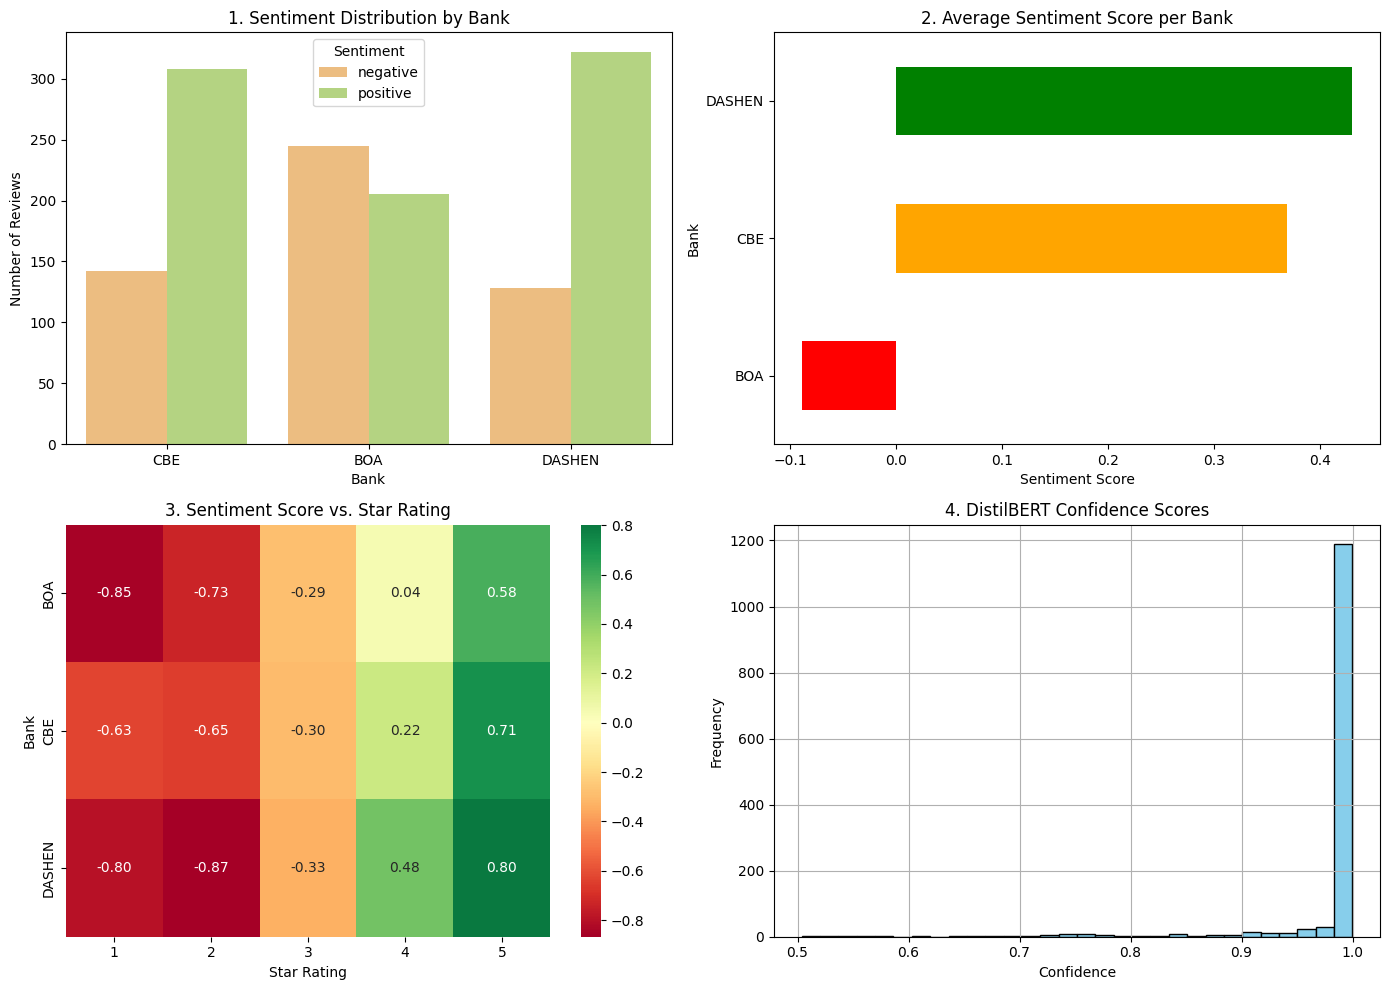

In [9]:
plot_bank_cx_insights(df,bank_sentiment)

In [10]:
# Save Sentiment Output
df.to_csv("../data/processed/reviews_with_sentiment_bert.csv", index=False)
print("💾 Saved processed sentiment dataset.")


💾 Saved processed sentiment dataset.


### 3. Thematic Analysis

In [11]:
# Preprocess + assign themes
df = apply_full_thematic_analysis(df)
df.head(20)

Preprocessing reviews...
Assigning themes...

Theme Distribution:
theme
No Content               534
Other                    461
Transaction Problems     102
Positive Experience       76
Missing Features          54
Slow Performance          31
Account Access Issues     27
App Crashes & Bugs        23
Customer Support          19
User Interface Issues     13
Name: count, dtype: int64


,review,rating,date,bank,source,sentiment,confidence,sentiment_score,processed_review,theme
0,The CBE MB app is best and updated with so man...,2,2025-07-11,CBE,Google Play Store,negative,0.995986,-1,update feature time time impossible download s...,Missing Features
1,niiceh,5,2025-10-29,CBE,Google Play Store,positive,0.877954,1,,No Content
2,the most advanced app. but how to stay safe?,5,2025-11-27,CBE,Google Play Store,negative,0.956509,-1,advanced stay safe,Security Concerns
3,it's best app to use recently and upgraded day...,4,2025-09-16,CBE,Google Play Store,positive,0.998349,1,use upgrade day day internationalization,Other
4,good,3,2025-11-01,CBE,Google Play Store,positive,0.999816,1,,No Content
5,The connection between bank and the app is lag...,4,2025-08-25,CBE,Google Play Store,negative,0.999582,-1,connection lag relationship correct,Slow Performance
6,why removing screenshot feature why?,2,2025-10-08,CBE,Google Play Store,negative,0.998115,-1,remove screenshot feature,Missing Features
7,excited,5,2025-08-27,CBE,Google Play Store,positive,0.999777,1,excite,Other
8,absolutely excellent,5,2025-09-04,CBE,Google Play Store,positive,0.999859,1,,No Content
9,very good,5,2025-07-20,CBE,Google Play Store,positive,0.999852,1,,No Content


In [12]:
# CREATE df_keywords – clean, sorted, ready for everything for analysis
bank_keywords = {
    bank: extract_keywords(
        df[df["bank"] == bank]["processed_review"].tolist(),
        top_k=20
    )
    for bank in df["bank"].unique()
}

bank_keywords

{'CBE': [('update', 0.027415744375603603),
  ('work', 0.026552879728532416),
  ('time', 0.016755616373197228),
  ('thank', 0.01642932310191036),
  ('use', 0.015717195012956486),
  ('transaction', 0.014913631367509686),
  ('account', 0.014144091425592243),
  ('like', 0.014100577979291679),
  ('transfer', 0.013379569871408582),
  ('money', 0.012136400967488284),
  ('option', 0.010832910136124273),
  ('useful', 0.010483954269191433),
  ('fast', 0.010428010668394683),
  ('easy', 0.009889576144245758),
  ('service', 0.009610849218414017),
  ('need', 0.0094151806861729),
  ('user', 0.009342107471286455),
  ('history', 0.008869087728452485),
  ('feature', 0.00846196802039166),
  ('day', 0.008236163295619568)],
 'BOA': [('work', 0.08040875398303358),
  ('use', 0.026940615522489584),
  ('open', 0.021184560411337428),
  ('time', 0.01930724729147393),
  ('update', 0.019258851381594357),
  ('fast', 0.018127717843061077),
  ('slow', 0.017650808959340125),
  ('experience', 0.01707836138855012),
  ('

In [15]:
# create df_keywords for visualization and analysis
import pandas as pd
rows = []
for bank, keyword_list in bank_keywords.items():
    for rank, (keyword, score) in enumerate(keyword_list, 1):
        rows.append({
            "Bank": bank,
            "Rank": rank,
            "Keyword": keyword,
            "TF-IDF Score": score
        })

# Create the DataFrame
df_keywords = pd.DataFrame(rows)

# Sort properly: first by Bank, then by Score descending
df_keywords = df_keywords.sort_values(["Bank", "TF-IDF Score"], ascending=[True, False]).reset_index(drop=True)
df_keywords.groupby(['Bank','Rank']).first()

Keyword  TF-IDF Score
Bank   Rank                           
BOA    1            work      0.080409
       2             use      0.026941
       3            open      0.021185
       4            time      0.019307
       5          update      0.019259
       6            fast      0.018128
       7            slow      0.017651
       8      experience      0.017078
       9         service      0.016883
       10            fix      0.015890
       11          crash      0.015040
       12           need      0.014899
       13            try      0.014441
       14          thank      0.014120
       15      developer      0.014029
       16          phone      0.012037
       17         option      0.011676
       18        useless      0.011497
       19    transaction      0.010762
       20        problem      0.010369
CBE    1          update      0.027416
       2            work      0.026553
       3            time      0.016756
       4           thank      0.016429
       5             use      0.015717
       6     transaction      0.014914
       7         account      0.014144
       8            like      0.014101
       9        transfer      0.013380
       10          money      0.012136
       11         option      0.010833
       12         useful      0.010484
       13           fast      0.010428
       14           easy      0.009890
       15        service      0.009611
       16           need      0.009415
       17           user      0.009342
       18        history      0.008869
       19        feature      0.008462
       20            day      0.008236
DASHEN 1           super      0.033507
       2            easy      0.031181
       3            fast      0.030194
       4            work      0.029858
       5             use      0.029055
       6            slow      0.023415
       7         feature      0.019659
       8            user      0.019284
       9            need      0.016368
       10     experience      0.016300
       11           time      0.016267
       12    transaction      0.015839
       13       friendly      0.015544
       14       easy use      0.015012
       15        service      0.014679
       16           step      0.014083
       17            new      0.013992
       18          thank      0.013127
       19         secure      0.012691
       20        payment      0.012337

In [13]:
print("THEME DISTRIBUTION ACROSS ALL BANKS")
theme_counts = df["theme"].value_counts()
print(theme_counts)

# Per-bank theme breakdown
print("\nTHEMES BY BANK")
theme_by_bank = df.groupby(["bank", "theme"]).size().unstack(fill_value=0)
theme_by_bank = theme_by_bank[theme_counts.index]  # same order
display(theme_by_bank.style.background_gradient(cmap="YlOrRd", axis=1))

THEME DISTRIBUTION ACROSS ALL BANKS
theme
No Content               534
Other                    461
Transaction Problems     102
Positive Experience       76
Missing Features          54
Slow Performance          31
Account Access Issues     27
App Crashes & Bugs        23
Customer Support          19
User Interface Issues     13
Security Concerns         10
Name: count, dtype: int64

THEMES BY BANK


theme,No Content,Other,Transaction Problems,Positive Experience,Missing Features,Slow Performance,Account Access Issues,App Crashes & Bugs,Customer Support,User Interface Issues,Security Concerns
bank,,,,,,,,,,,
BOA,167,178,25,14,13,15,9,18,5,5,1
CBE,218,139,37,13,17,3,9,1,8,2,3
DASHEN,149,144,40,49,24,13,9,4,6,6,6


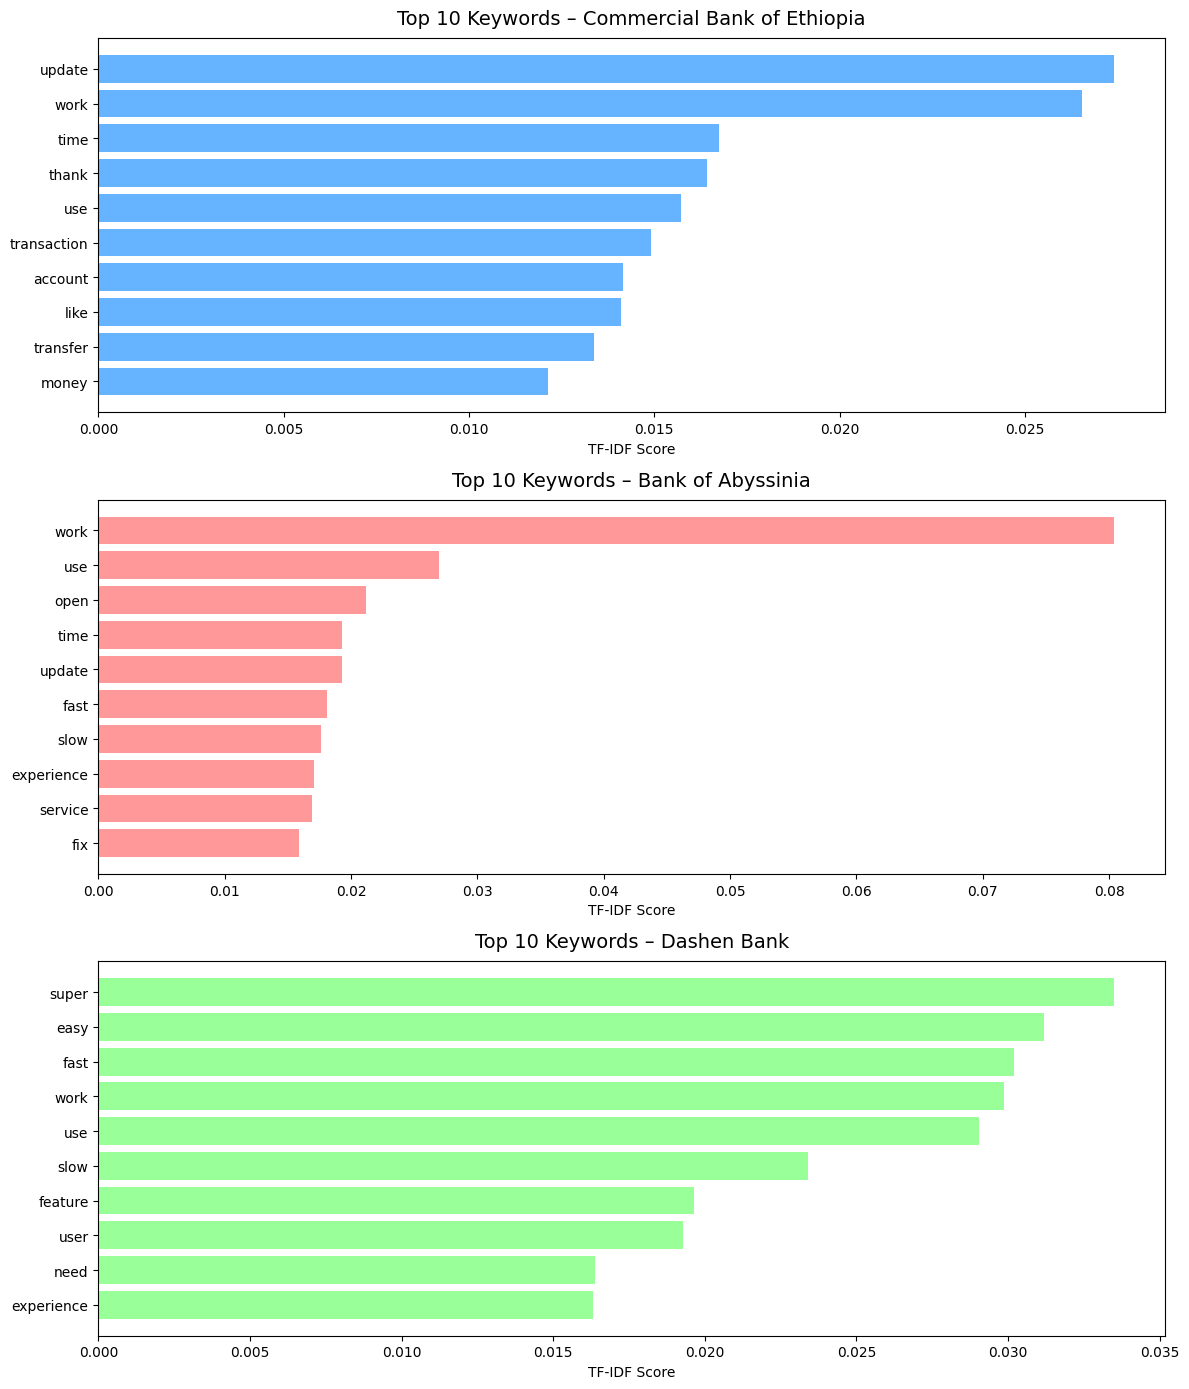

<Figure size 1200x800 with 0 Axes>

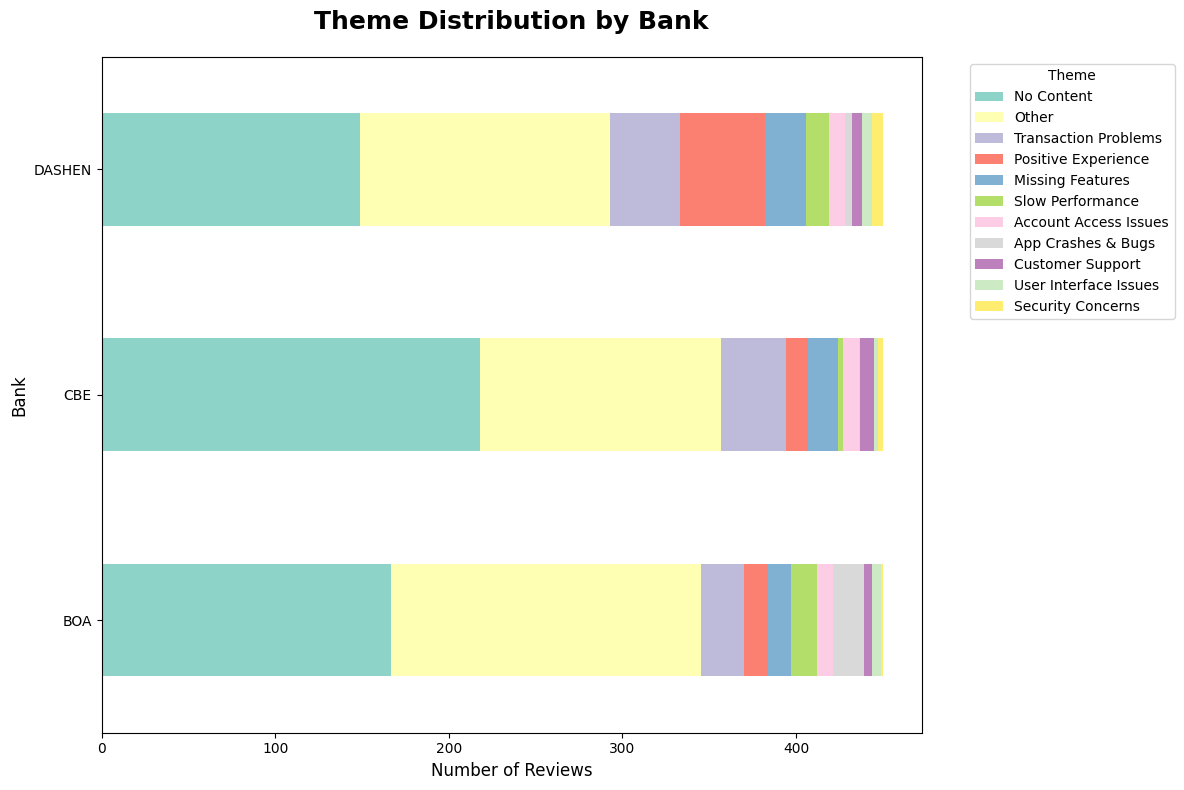

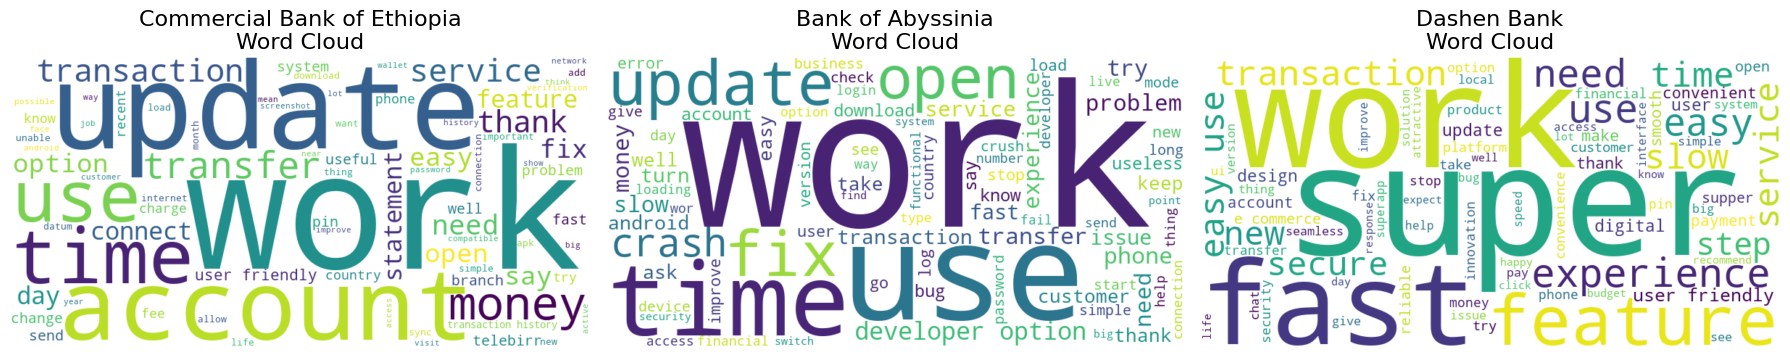

In [16]:
# Assuming you already have these objects ready:
# df, bank_sentiment, df_keywords, theme_by_bank
plot_top_keywords_per_bank(df_keywords, top_n=10)
plot_theme_distribution(theme_by_bank)
plot_wordclouds(df, banks=["CBE", "BOA", "DASHEN"])

In [17]:
# Save Sentiment Output
df.to_csv("../data/processed/cleaned_reviews_with_themes.csv", index=False)
print("💾 Saved processed sentiment dataset.")

💾 Saved processed sentiment dataset.
